PyTorch UNet implementation using IceNet library for data download and post-processing of sea ice forecasting.

This notebook has been designed to be independent of other notebooks.

### Highlights
The key features of this notebook are:
* [1. Download](#1.-Download) 
* [2. Data Processing](#2.-Data-Processing)
* [3. Train](#3.-Train)
* [4. Prediction](#4.-Prediction)
* [5. Outputs and Plotting](#5.-Outputs-and-Plotting)

Please note that this notebook relies on a pytorch data loader implementation which is only available from icenet v0.2.8+.

To install the necessary python packages, you can use the conda `icenet-notebooks/pytorch/environment.yml` environment file on a Linux system to be able to set-up the necessary pytorch + tensorflow + CUDA + other modules which could be a tricky mix to get working manually:

```bash
conda env create -f environment.yml
```

### Contributions
#### PyTorch implementation of UnetDiffusion
Maria Carolina Novitasari

#### PyTorch implementation of IceNet

Andrew McDonald ([icenet-gan](https://github.com/ampersandmcd/icenet-gan))

Bryn Noel Ubald (Refactor, updates for daily predictions and matching icenet library)

#### Notebook
Bryn Noel Ubald (author)

#### PyTorch Integration
Bryn Noel Ubald

Ryan Chan

### How to Download Daily Data for IceNet

#### DOWNLOAD SIC Data  

To download Sea Ice Concentration (SIC) data, modify the script below with the desired date range:

```python
sic = SICDownloader(
    dates=[
        pd.to_datetime(date).date()  # Dates to download SIC data for
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    delete_tempfiles=True,           # Delete temporary downloaded files after use
    north=False,                     # Use mask for the Northern Hemisphere (set to True if needed)
    south=True,                      # Use mask for the Southern Hemisphere
    parallel_opens=True,             # Enable parallel processing with dask.delayed
)

sic.download()
```

#### Download ERA5 Data  

##### Setup ERA5 API

Use the following link to set up the ERA5 API: [https://cds.climate.copernicus.eu/how-to-api?](https://cds.climate.copernicus.eu/how-to-api?).

Run the following script with your desired dates:

#### ERA5 Downloader  

```python
import pandas as pd
from icenet.data.interfaces.cds import ERA5Downloader

era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],      # Name of variables to download
    dates=[                                     # Dates to download the variable data for
        pd.to_datetime(date).date()
        for date in pd.date_range("2020-01-01", "2020-12-31", freq="D")
    ],
    path="./data",                              # Location to download data to (default is `./data`)
    delete_tempfiles=True,                      # Whether to delete temporary downloaded files
    levels=[None, [250, 500], None, None],      # The levels at which to obtain the variables for (e.g. for zg, it is the pressure levels)
    max_threads=4,                              # Maximum number of concurrent downloads
    north=False,                                # Boolean: Whether require data across northern hemisphere
    south=True,                                 # Boolean: Whether require data across southern hemisphere
    use_toolbox=False)                          # Experimental, alternative download method

era5.download()                                 # Start downloading
```

The prototype data currently in use (South Pole, 2020) can be downloaded from **Baskerville** at the following path: `/vjgo8416-ice-frcst/shared/prototype_data/`

In [1]:
import os
import numpy as np
import pandas as pd
import random

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import math
from typing import Tuple
from torchmetrics import Metric
import lightning.pytorch as pl
from lightning.pytorch.utilities.types import TRAIN_DATALOADERS
from torchmetrics import MetricCollection
from torch_ema import ExponentialMovingAverage
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

# We also set the logging level so that we get some feedback from the API
import logging
logging.basicConfig(level=logging.INFO)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_float32_matmul_precision('high')

In [2]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(os.getcwd())

from models import GaussianDiffusion, UNetDiffusion, LitDiffusion
from trainers import DiffusionTrainer
from omegaconf import OmegaConf

cfg = OmegaConf.load("../configs/ddpm_config.yaml")

/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks


2025-10-22 18:06:08.720277: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-22 18:06:08.767110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-22 18:06:08.767140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-22 18:06:08.768651: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-22 18:06:08.778030: I tensorflow/core/platform/cpu_feature_guar

In [3]:
seed = cfg.train.seed

torch.manual_seed(seed)           # PyTorch CPU
torch.cuda.manual_seed(seed)      # PyTorch single GPU
torch.cuda.manual_seed_all(seed)  # PyTorch multi-GPU
np.random.seed(seed)              # NumPy
random.seed(seed)                 # Python built-in random

In [4]:
from datetime import datetime
import sys

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
sys.stdout = open(f'training_logs/training_log_{timestamp}_refactor.txt', 'w')

## 1. Download

In [5]:
import numpy
from icenet.data.sic.mask import Masks
from icenet.data.interfaces.cds import ERA5Downloader
from icenet.data.sic.osisaf import SICDownloader

In [6]:
# Unset SLURM_NTASKS if it's causing issues
if "SLURM_NTASKS" in os.environ:
    del os.environ["SLURM_NTASKS"]

# Optionally, set SLURM_NTASKS_PER_NODE if needed
os.environ["SLURM_NTASKS_PER_NODE"] = "1"  # or whatever value is appropriate

### Mask data

Create masks for masking data.

In [7]:
masks = Masks(north=True, south=False)
masks.generate(save_polarhole_masks=False)

INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_01.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_02.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_03.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_04.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_05.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_06.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_07.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_08.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_09.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_10.npy, already exists
INFO:root:Skipping ./data/masks/north/masks/active_grid_cell_mask_11.npy, already exists
INFO:root:Skipping ./

### Climate and Sea Ice data

Download climate variables from ERA5 and sea ice concentration from OSI-SAF.

In [8]:
era5 = ERA5Downloader(
    var_names=["tas", "zg", "uas", "vas"],
    levels=[None, [250, 500], None, None],
    dates=[pd.to_datetime(date).date() for date in
           # pd.date_range("2020-01-01", "2020-04-30", freq="D")],
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    max_threads=64,
    north=True,
    south=False,
    # NOTE: there appears to be a bug with the toolbox API at present (icenet#54)
    use_toolbox=False
)

# era5.download()

INFO:root:Upping connection limit for max_threads > 10


In [9]:
sic = SICDownloader(
    dates=[pd.to_datetime(date).date() for date in
           # pd.date_range("2020-01-01", "2020-04-30", freq="D")],
           pd.date_range("2018-01-01", "2020-12-31", freq="D")],
    delete_tempfiles=False,
    north=True,
    south=False,
    parallel_opens=False,
)

# sic.download()

Re-grid ERA5 reanalysis data, and rotate wind vector data from ERA5 to align with EASE2 projection.

In [10]:
era5.regrid()
era5.rotate_wind_data()

INFO:root:No regrid batches to processing, moving on...
INFO:root:Rotating wind data prior to merging
INFO:root:Rotating wind data in ./data/era5/north/uas ./data/era5/north/vas
INFO:root:0 files for uas
INFO:root:0 files for vas
INFO:root:Rotating wind data in ./data/era5/north/uas ./data/era5/north/vas
INFO:root:0 files for uas
INFO:root:0 files for vas


## 2. Data Processing

Process downloaded datasets.

To make life easier, setting up train, val, test dates.

In [11]:
# 1to7Apr 2018-2020
processing_dates = dict(
    train=[pd.to_datetime(el) for el in pd.date_range("2018-01-01", "2019-03-29")],
    val=[pd.to_datetime(el) for el in pd.date_range("2019-03-30", "2019-06-30")],
    test=[pd.to_datetime(el) for el in pd.date_range("2020-04-01", "2020-04-07")],
)
processed_name = "notebook_api_pytorch_data"

Next, we create the data producer and configure them for the dataset we want to create.

In [12]:
from icenet.data.processors.era5 import IceNetERA5PreProcessor
from icenet.data.processors.meta import IceNetMetaPreProcessor
from icenet.data.processors.osi import IceNetOSIPreProcessor

pp = IceNetERA5PreProcessor(
    ["uas", "vas"],
    ["tas", "zg500", "zg250"],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=True,
    south=False,
)

osi = IceNetOSIPreProcessor(
    ["siconca"],
    [],
    processed_name,
    processing_dates["train"],
    processing_dates["val"],
    processing_dates["test"],
    linear_trends=tuple(),
    north=True,
    south=False,
)

meta = IceNetMetaPreProcessor(
    processed_name,
    north=True,
    south=False,
)

Next, we initialise the data processors using `init_source_data` which scans the data source directories to understand what data is available for processing based on the parameters. Since we named the processed data `"notebook_api_data"` above, it will create a data loader config file, `loader.notebook_api_data.json`, in the current directory.

In [13]:
# Causes hanging on training, when generating sample.
pp.init_source_data(
    lag_days=1,
)
pp.process()

osi.init_source_data(
    lag_days=1,
)
osi.process()

meta.process()

INFO:root:Processing 453 dates for train category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 93 dates for val category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Processing 7 dates for test category
INFO:root:Including lag of 1 days
INFO:root:Including lead of 93 days
INFO:root:Got 4 files for tas
INFO:root:Got 4 files for uas
INFO:root:Got 4 files for vas
INFO:root:Got 4 files for zg250
INFO:root:Got 4 files for zg500
INFO:root:Opening files for uas
INFO:root:Filtered to 1461 units long based on configuration requirements
INFO:root:Normalising uas
INFO:root:Opening files for vas
INFO:root:Filtered to 1461 units long based on configuration requirements
INFO:root:Normalising vas
INFO:root:Opening files for tas
INFO:root:Filtered to 1461 units long based on configuration requirements
INFO:root:Reusing climatology ./processed/notebook_api_pytorch_data/era5/north/params/climatology.tas
INFO:root:Normalisin

At this point the preprocessed data is ready to convert or create a configuration for the network dataset.

### Dataset creation

As with the `icenet_dataset_create` command we can create a dataset configuration for training the network. As before this can include cached data for the network in the format of a TFRecordDataset compatible set of tfrecords. To achieve this we create the `IceNetDataLoader`, which can both generate `IceNetDataSet` configurations (which easily provide the necessary functionality for training and prediction) as well as individual data samples for direct usage.

In [14]:
from icenet.data.loaders import IceNetDataLoaderFactory

implementation = "dask"
loader_config = "loader.notebook_api_pytorch_data.json"
dataset_name = "notebook_api_pytorch_data"
lag = 1

dl = IceNetDataLoaderFactory().create_data_loader(
    implementation,
    loader_config,
    dataset_name,
    lag,
    n_forecast_days=7,
    north=True,
    south=False,
    output_batch_size=1,
    generate_workers=4)

INFO:root:Loading configuration loader.notebook_api_pytorch_data.json


At this point we can either use `generate` or `write_dataset_config_only` to produce a ready-to-go `IceNetDataSet` configuration. Both of these will generate a dataset config, `dataset_config.notebook_api_pytorch_data.json` (recall we set the dataset name as `notebook_api_pytorch_data` above).

In this case, for pytorch, will read data in directly, rather than using cached tfrecords inputs.

In [15]:
dl.write_dataset_config_only()

INFO:root:Writing dataset configuration without data generation
INFO:root:453 train dates in total, NOT generating cache data.
INFO:root:93 val dates in total, NOT generating cache data.
INFO:root:7 test dates in total, NOT generating cache data.
INFO:root:Writing configuration to ./dataset_config.notebook_api_pytorch_data.json


We can now create the IceNetDataSet object:

In [16]:
from icenet.data.dataset import IceNetDataSetPyTorch
dataset_config = f"dataset_config.{dataset_name}.json"

## 3. Train

We implement a custom PyTorch class for training.

## IceNet2 U-Net Diffusion model

Maria's work (PyTorch Diffusion using U-Net)

In [17]:
class Interpolate(nn.Module):
    def __init__(self, scale_factor, mode):
        super().__init__()
        self.interp = F.interpolate
        self.scale_factor = scale_factor
        self.mode = mode

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode=self.mode)
        return x

Define custom metrics for use in validation and monitoring

Define custom loss functions

A _LightningModule_ wrapper for UNetDiffusion model.

Function for training UNetDiffusion model using PyTorch Lightning.

Conduct actual training run.

In [ ]:
diffusion_trainer = DiffusionTrainer(cfg)
model, trainer_obj, checkpoint_callback = diffusion_trainer.train()

[rank: 0] Seed set to 45
INFO:trainers.diffusion_trainer:Setting up datasets and dataloaders...
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
INFO:trainers.diffusion_trainer:Batch shapes - X: torch.Size([8, 432, 432, 9]), Y: torch.Size([8, 432, 432, 7, 1]), Weights: torch.Size([8, 432, 432, 7, 1])
INFO:trainers.diffusion_trainer:Setting up diffusion model...
/bask/homes/l/llcu4279/vjgo8416-ice-frcst/users/llcu4279/myenv/miniconda3/envs/seaice_env3/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.M

## 4. Prediction

Predicts using the best checkpoint from the training.

In [60]:
checkpoint_callback.best_k_models

{'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20251022_180701/checkpoints/diffusion-epoch=12-val_accuracy=97.1774.ckpt': tensor(97.1774),
 '/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20251022_180701/checkpoints/diffusion-epoch=13-val_accuracy=97.2087.ckpt': tensor(97.2087),
 '/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20251022_180701/checkpoints/diffusion-epoch=14-val_accuracy=97.2281.ckpt': tensor(97.2281)}

In [61]:
# best_checkpoint = checkpoint_callback.best_model_path
best_checkpoint = "/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20251022_180701/checkpoints/last.ckpt"
best_checkpoint 

'/bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20251022_180701/checkpoints/last.ckpt'

In [62]:
# Load the best result from the checkpoint
best_model = LitDiffusion.load_from_checkpoint(best_checkpoint)

# disable randomness, dropout, etc...
best_model.eval()

LitDiffusion(
  (model): UNetDiffusion(
    (time_embed): TimeEmbed(
      (model): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): SiLU(inplace=True)
        (2): Linear(in_features=1024, out_features=256, bias=True)
      )
    )
    (conv1): CommonConvBlock(
      (block1): ConvNormAct(
        (block): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (2): SiLU(inplace=True)
        )
      )
      (block2): ConvNormAct(
        (block): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): GroupNorm(8, 32, eps=1e-05, affine=True)
          (2): SiLU(inplace=True)
        )
      )
    )
    (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): CommonConvBlock(
      (block1): ConvNormAct(
        (block): Sequential(
          (0): Conv

In [63]:
test_dataset = IceNetDataSetPyTorch(configuration_path=dataset_config, mode="test")
test_dataloader = DataLoader(test_dataset, batch_size=cfg.train.dataloader.batch_size, num_workers=cfg.train.dataloader.n_workers,
                             persistent_workers=cfg.train.dataloader.persistent_workers, shuffle=cfg.train.dataloader.shuffle)

# automatically load the best weights (if best_model isn't added)
diffusion_trainer.trainer.test(dataloaders=test_dataloader)

INFO:root:Loading configuration dataset_config.notebook_api_pytorch_data.json
INFO:root:Loading configuration /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/loader.notebook_api_pytorch_data.json
Restoring states from the checkpoint path at /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20251022_180701/checkpoints/diffusion-epoch=14-val_accuracy=97.2281.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /bask/projects/v/vjgo8416-ice-frcst/users/llcu4279/github_zebra/ice-station-zebra/notebooks/training/local/diffusion_run_20251022_180701/checkpoints/diffusion-epoch=14-val_accuracy=97.2281.ckpt


[{'test_loss': 14.819432258605957,
  'test_accuracy': 97.08251190185547,
  'test_accuracy_0': 98.21363830566406,
  'test_accuracy_1': 97.64395141601562,
  'test_accuracy_2': 96.84185791015625,
  'test_accuracy_3': 97.21907043457031,
  'test_accuracy_4': 96.88395690917969,
  'test_accuracy_5': 96.64424133300781,
  'test_accuracy_6': 96.1308364868164,
  'test_sieerror': 27790000.0,
  'test_sieerror_0': 2919375.0,
  'test_sieerror_1': 2859375.0,
  'test_sieerror_2': 7000000.0,
  'test_sieerror_3': 1128125.0,
  'test_sieerror_4': 3026250.0,
  'test_sieerror_5': 3998125.0,
  'test_sieerror_6': 6858750.0}]

In [64]:
logging.info("Generating predictions")

predictions = diffusion_trainer.trainer.predict(best_model, dataloaders=test_dataloader)

INFO:root:Generating predictions
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [65]:
predictions = [p.unsqueeze(-2) for p in predictions]

for worker, prediction in enumerate(predictions):
    print(f"Worker: {worker} | Prediction: {prediction.shape}")

## 5. Outputs and Plotting

Create prediction output directory

In [66]:
# dataset = "pytorch_notebook"
network_name = "api_pytorch_dataset"
output_name = "example_pytorch_forecast_test"
output_folder = os.path.join(".", "results", "predict", output_name,
                                "{}.{}".format(network_name, cfg.train.seed))
os.makedirs(output_folder, exist_ok=output_folder)

Convert and output predictions to numpy files

In [67]:
idx = 0
for workers, prediction in enumerate(predictions):
    for batch in range(prediction.shape[0]):
        date = pd.Timestamp(test_dataset.dates[idx].replace('_', '-'))
        output_path = os.path.join(output_folder, date.strftime("%Y_%m_%d.npy"))
        forecast = prediction[batch, :, :, :, :].movedim(-2, 0)
        forecast_np = forecast.detach().cpu().numpy()
        np.save(output_path, forecast_np)
        idx += 1

Create a csv file with all the test dates we have predicted for, and to use in generating the final netCDF output using `icenet_output`.

In [68]:
!printf "2020-04-01\n2020-04-02" | tee testdates.csv

In [69]:
import sys
!{sys.executable.replace('python', 'icenet_output')}  -m -o results/predict example_pytorch_forecast_test notebook_api_pytorch_data testdates.csv

INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761152821.bask-pg0308u03a.1900963.0 to lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1 to lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2 to lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3 to lightning_logs/version_1127781/events.out.tfevents.1761226020.bask-pg0308u03a.1900963.4
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/eve

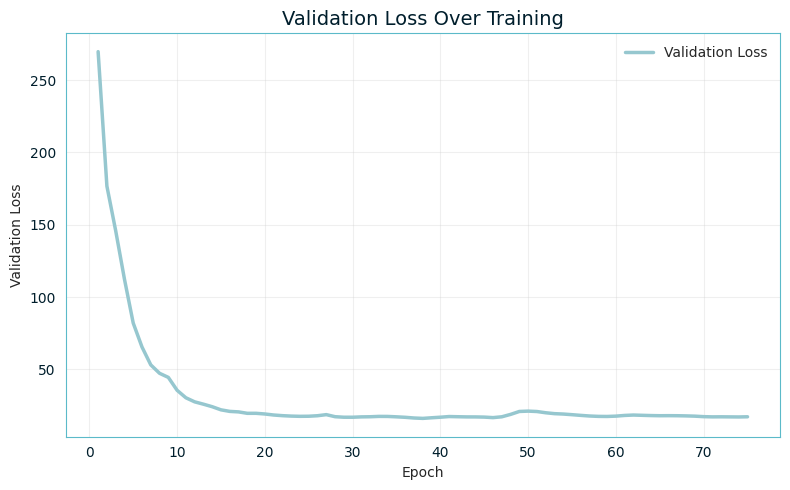

In [70]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style for consistency
sns.set_style("whitegrid")

ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]

# Change this to the actual version dir
# log_dir = "lightning_logs/version_1117456" 
log_dir = max([os.path.join("lightning_logs", d) for d in os.listdir("lightning_logs") if d.startswith("version_")], key=os.path.getctime)


# Load the logs
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# List all scalar tags to find the correct name
print("Available tags:", event_acc.Tags()['scalars'])

# Get the scalar events for val_loss
val_loss_events = event_acc.Scalars('val_loss')

steps = list(range(1, len(val_loss_events) + 1))
values = [e.value for e in val_loss_events]

# Plot with custom color theme
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Loss', color=ppt_colors[1], linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Over Training", fontsize=14, color=ppt_colors[3])
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

# Adjust tick/label colors to match theme
plt.gca().tick_params(colors=ppt_colors[3])
for spine in plt.gca().spines.values():
    spine.set_color(ppt_colors[2])

plt.tight_layout()
# Save the figure before showing
plt.savefig("val_loss_plot_ddpm_ISAR_prototype_2018_2020_NORTH_test1to7Apr.png", dpi=300, bbox_inches='tight')
plt.show()


INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761152821.bask-pg0308u03a.1900963.0 to lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1 to lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2 to lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3 to lightning_logs/version_1127781/events.out.tfevents.1761226020.bask-pg0308u03a.1900963.4
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/eve

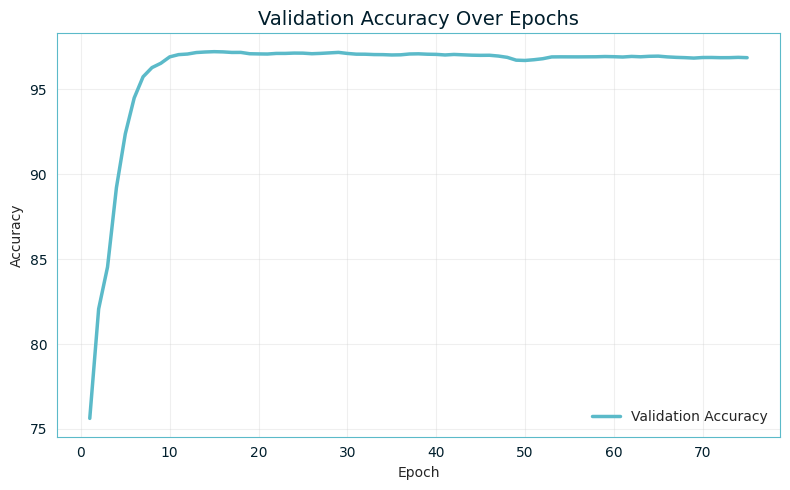

In [71]:


import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Set seaborn style for consistency
sns.set_style("whitegrid")

# Custom ppt color palette
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]

# Update with your actual path
# log_dir = "lightning_logs/version_1117456" 
log_dir = max([os.path.join("lightning_logs", d) for d in os.listdir("lightning_logs") if d.startswith("version_")], key=os.path.getctime)

event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Get accuracy for all lead times (overall accuracy)
accuracy_events = event_acc.Scalars('val_accuracy')
steps = list(range(1, len(accuracy_events) + 1))
values = [e.value for e in accuracy_events]

# Plot with custom color theme
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Accuracy', color=ppt_colors[2], linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs", fontsize=14, color=ppt_colors[3])
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

# Adjust tick/label colors to match theme
plt.gca().tick_params(colors=ppt_colors[3])
plt.gca().spines['bottom'].set_color(ppt_colors[2])
plt.gca().spines['left'].set_color(ppt_colors[2])
plt.gca().spines['right'].set_color(ppt_colors[2])
plt.gca().spines['top'].set_color(ppt_colors[2])

plt.tight_layout()
plt.savefig("val_acc_plot_ddpm_ISAR_prototype_2018_2020_NORTH_test1to7Apr.png", dpi=300, bbox_inches='tight')
plt.show()


INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761152821.bask-pg0308u03a.1900963.0 to lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1 to lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2 to lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3 to lightning_logs/version_1127781/events.out.tfevents.1761226020.bask-pg0308u03a.1900963.4
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/eve

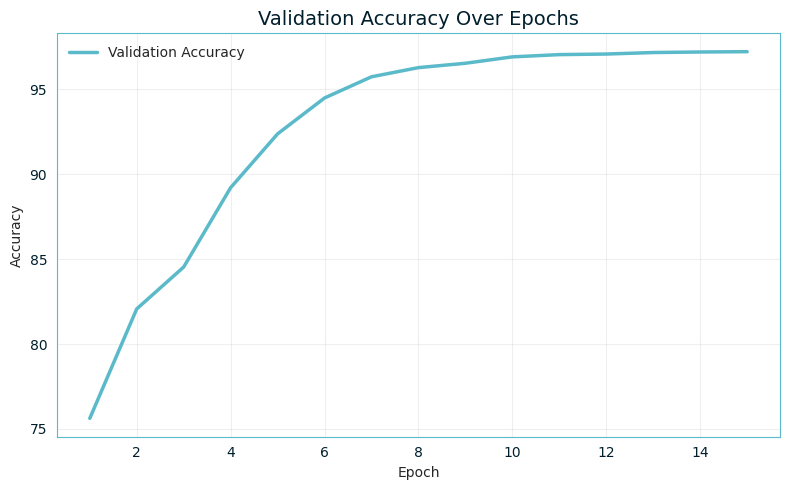

In [72]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Set seaborn style for consistency
sns.set_style("whitegrid")

# Custom ppt color palette
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]

# Update with your actual path
# log_dir = "lightning_logs/version_1117456"
log_dir = max(
    [os.path.join("lightning_logs", d) for d in os.listdir("lightning_logs") if d.startswith("version_")],
    key=os.path.getctime
)

event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Get accuracy for all lead times (overall accuracy)
accuracy_events = event_acc.Scalars('val_accuracy')

# Define epoch range
start_epoch = 1
end_epoch = 15

# Extract steps and values, limited to epochs 1–30
steps = list(range(1, len(accuracy_events) + 1))
values = [e.value for e in accuracy_events]

# Slice to only include epochs 1 to 30
steps = steps[start_epoch - 1:end_epoch]
values = values[start_epoch - 1:end_epoch]

# Plot with custom color theme
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Accuracy', color=ppt_colors[2], linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs", fontsize=14, color=ppt_colors[3])
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

# Adjust tick/label colors to match theme
plt.gca().tick_params(colors=ppt_colors[3])
for spine in plt.gca().spines.values():
    spine.set_color(ppt_colors[2])

plt.tight_layout()
plt.savefig("val_acc_plot_epochs_1to15.png", dpi=300, bbox_inches='tight')
plt.show()

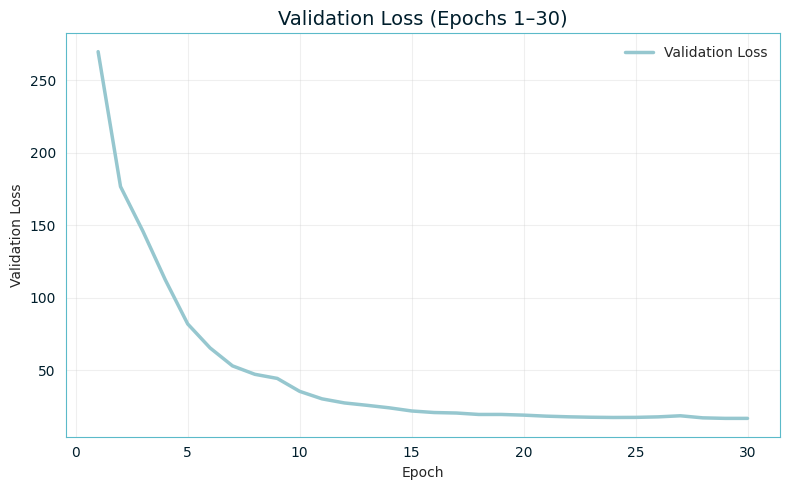

In [73]:
# Limit to epochs 1–30
start_epoch = 1
end_epoch = 30

# Slice the data (Python uses 0-based indexing)
steps = list(range(1, len(val_loss_events) + 1))
values = [e.value for e in val_loss_events]

# Filter only epochs 1 to 30
steps = steps[start_epoch - 1:end_epoch]
values = values[start_epoch - 1:end_epoch]

# Plot with custom color theme
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Loss', color=ppt_colors[1], linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss (Epochs 1–30)", fontsize=14, color=ppt_colors[3])
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

# Adjust tick/label colors to match theme
plt.gca().tick_params(colors=ppt_colors[3])
for spine in plt.gca().spines.values():
    spine.set_color(ppt_colors[2])

plt.tight_layout()
plt.savefig("val_loss_plot_1to30.png", dpi=300, bbox_inches='tight')
plt.show()


INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761152821.bask-pg0308u03a.1900963.0 to lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201552.bask-pg0308u03a.1900963.1 to lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761201603.bask-pg0308u03a.1900963.2 to lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/events.out.tfevents.1761225968.bask-pg0308u03a.1900963.3 to lightning_logs/version_1127781/events.out.tfevents.1761226020.bask-pg0308u03a.1900963.4
INFO:tensorboard:Directory watcher advancing from lightning_logs/version_1127781/eve

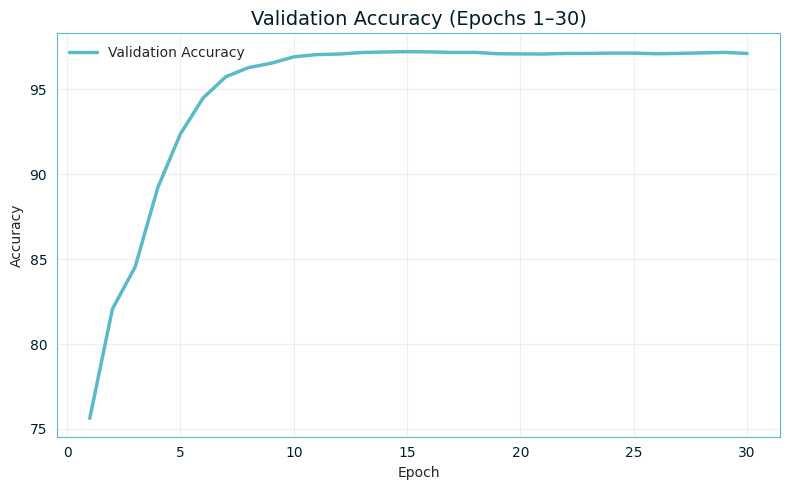

In [74]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# Set seaborn style for consistency
sns.set_style("whitegrid")

# Custom ppt color palette
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]

# Update with your actual path
# log_dir = "lightning_logs/version_1117456"
log_dir = max(
    [os.path.join("lightning_logs", d) for d in os.listdir("lightning_logs") if d.startswith("version_")],
    key=os.path.getctime
)

event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Get accuracy for all lead times (overall accuracy)
accuracy_events = event_acc.Scalars('val_accuracy')

# Define epoch range
start_epoch = 1
end_epoch = 30

# Extract steps and values, limited to epochs 1–30
steps = list(range(1, len(accuracy_events) + 1))
values = [e.value for e in accuracy_events]

# Slice to only include epochs 1 to 30
steps = steps[start_epoch - 1:end_epoch]
values = values[start_epoch - 1:end_epoch]

# Plot with custom color theme
plt.figure(figsize=(8, 5))
plt.plot(steps, values, label='Validation Accuracy', color=ppt_colors[2], linewidth=2.5)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy (Epochs 1–30)", fontsize=14, color=ppt_colors[3])
plt.legend(frameon=False)
plt.grid(True, alpha=0.3)

# Adjust tick/label colors to match theme
plt.gca().tick_params(colors=ppt_colors[3])
for spine in plt.gca().spines.values():
    spine.set_color(ppt_colors[2])

plt.tight_layout()
plt.savefig("val_acc_plot_epochs_1to30.png", dpi=300, bbox_inches='tight')
plt.show()


In [75]:
log_dir

'lightning_logs/version_1127781'

Plotting the forecast

In [76]:
import xarray as xr
import datetime as dt
from IPython.display import HTML

In [77]:
from icenet.plotting.video import xarray_to_video as xvid
from icenet.data.sic.mask import Masks

ds = xr.open_dataset("results/predict/example_pytorch_forecast_test.nc")
land_mask = Masks(south=False, north=True).get_land_mask()

ds.info()

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'cfgrib', 'pydap', 'rasterio', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

Animate result

In [ ]:
import pandas as pd
forecast_date = ds.time.values[0]
fc = ds.sic_mean.isel(time=0).drop_vars("time").rename(dict(leadtime="time"))
fc['time'] = [pd.to_datetime(forecast_date) \
              + dt.timedelta(days=int(e)) for e in fc.time.values]

anim = xvid(fc, 15, figsize=(4,4), mask=land_mask)
HTML(anim.to_jshtml())

Check min/max of predicted SIC fraction

In [ ]:
print( forecast_np[:, :, :, 0].shape )
fmin, fmax = np.min(forecast_np[:, :, :, 0]), np.max(forecast_np[:, :, :, 0])
print( f"First forecast day min: {fmin:.4f}, max: {fmax:.4f}" )

#### Load original input dataset

This is the original input dataset (pre-normalisation) for comparison.

## Version
- IceNet Codebase: v0.2.8

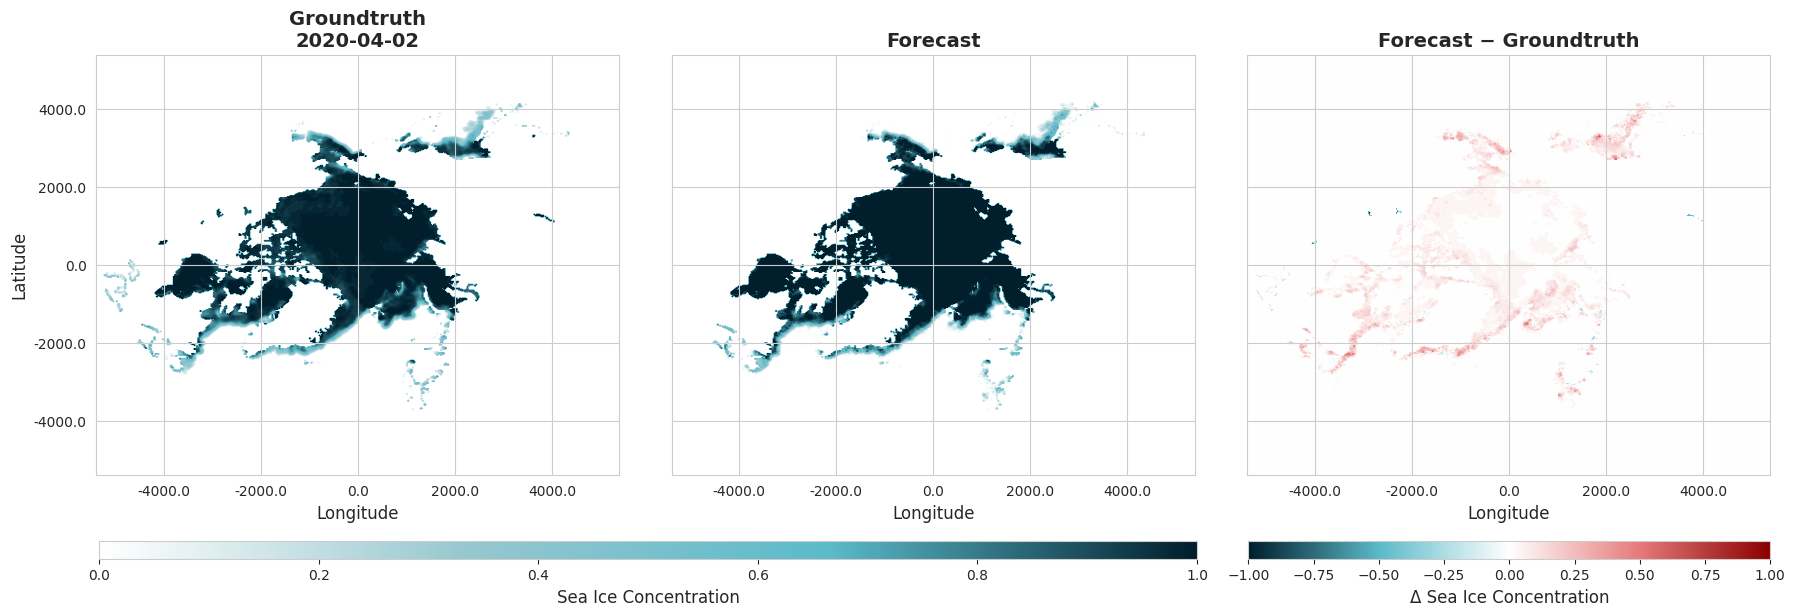

In [78]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# --- load / select frames ---
fc_flat = fc.isel(time=0)
timestamp = pd.to_datetime(fc.time.values[0])

ds = xr.open_dataset("data/osisaf/north/siconca/2020.nc")
# ice_conc = ds.isel(time=92).ice_conc #92 is 2 april 
# ice_conc = ds.isel(time=111).ice_conc #111 is 21 april
# ice_conc = ds.isel(time=93).ice_conc #93 is 3 april
ice_conc = ds.isel(time=91).ice_conc #91 is 1 april 

# --- align grids (important) ---
ice_conc_interp = ice_conc.interp_like(fc_flat)

# --- difference ---
diff = fc_flat - ice_conc_interp

# --- colormaps ---
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ppt_cmap", ppt_colors)

diff_colors = ["#001E2C", "#5BBAC9", "#FFFFFF", "#E67A7A", "#8B0000"]
diff_cmap = mcolors.LinearSegmentedColormap.from_list("diff_cmap", diff_colors)

# --- shared vmin/vmax for the main (gt + fc) maps ---
vmin_main = float(np.nanmin([ice_conc_interp.values.min(), fc_flat.values.min()]))
vmax_main = float(np.nanmax([ice_conc_interp.values.max(), fc_flat.values.max()]))

# --- symmetric scale for difference ---
vmax_diff = float(np.nanmax(np.abs(diff.values)))
vmin_diff = -vmax_diff

# --- figure & axes ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth
im0 = ice_conc_interp.plot.contourf(
    ax=axes[0],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[0].set_title(f"Groundtruth\n{timestamp.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Longitude", fontsize=12)
axes[0].set_ylabel("Latitude", fontsize=12)

# Forecast
im1 = fc_flat.plot.contourf(
    ax=axes[1],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[1].set_title("Forecast", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Longitude", fontsize=12)
axes[1].set_ylabel("")

# Difference
im2 = diff.plot.contourf(
    ax=axes[2],
    levels=50,
    cmap=diff_cmap,
    vmin=vmin_diff,
    vmax=vmax_diff,
    add_colorbar=False,
    zorder=0,
)
axes[2].set_title("Forecast − Groundtruth", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Longitude", fontsize=12)
axes[2].set_ylabel("")

# --- Clean up axis tick labels ---
for i, ax in enumerate(axes):
    # Format longitude and latitude labels to be cleaner
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Reduce the number of ticks for cleaner look
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    # Format tick labels to remove excessive decimals
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    # Remove y-axis labels for all except the first plot
    if i > 0:
        ax.set_yticklabels([])  # Remove y-tick labels but keep the ticks

# --- Better positioned colorbars ---
# Main colorbar - extended to match exact width of image 1 + image 2
cbar_ax1 = fig.add_axes([0.0515, 0.08, 0.61, 0.03])  # Extended width to match images 1+2
sm_main = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=vmin_main, vmax=vmax_main))
sm_main.set_array([])
cbar1 = fig.colorbar(sm_main, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Sea Ice Concentration", fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# Diff colorbar - extended to match exact width of image 3
cbar_ax2 = fig.add_axes([0.69, 0.08, 0.29, 0.03])  # Extended width to match image 3
sm_diff = plt.cm.ScalarMappable(cmap=diff_cmap, norm=plt.Normalize(vmin=vmin_diff, vmax=vmax_diff))
sm_diff.set_array([])
cbar2 = fig.colorbar(sm_diff, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("Δ Sea Ice Concentration", fontsize=12)
cbar2.ax.tick_params(labelsize=10)

# Adjust layout to make more room for colorbars (increased bottom margin)
plt.subplots_adjust(top=0.92, bottom=0.22, left=0.05, right=0.98, wspace=0.1)

plt.savefig(
    f"ddpm_forecast_comparison_{timestamp.strftime('%Y%m%d')}_ISAR8_PROTOTYPE_2018_2020_NORTH_test1to7Apr.png",
    dpi=300,
    bbox_inches="tight",
    facecolor='white'
)
plt.show()

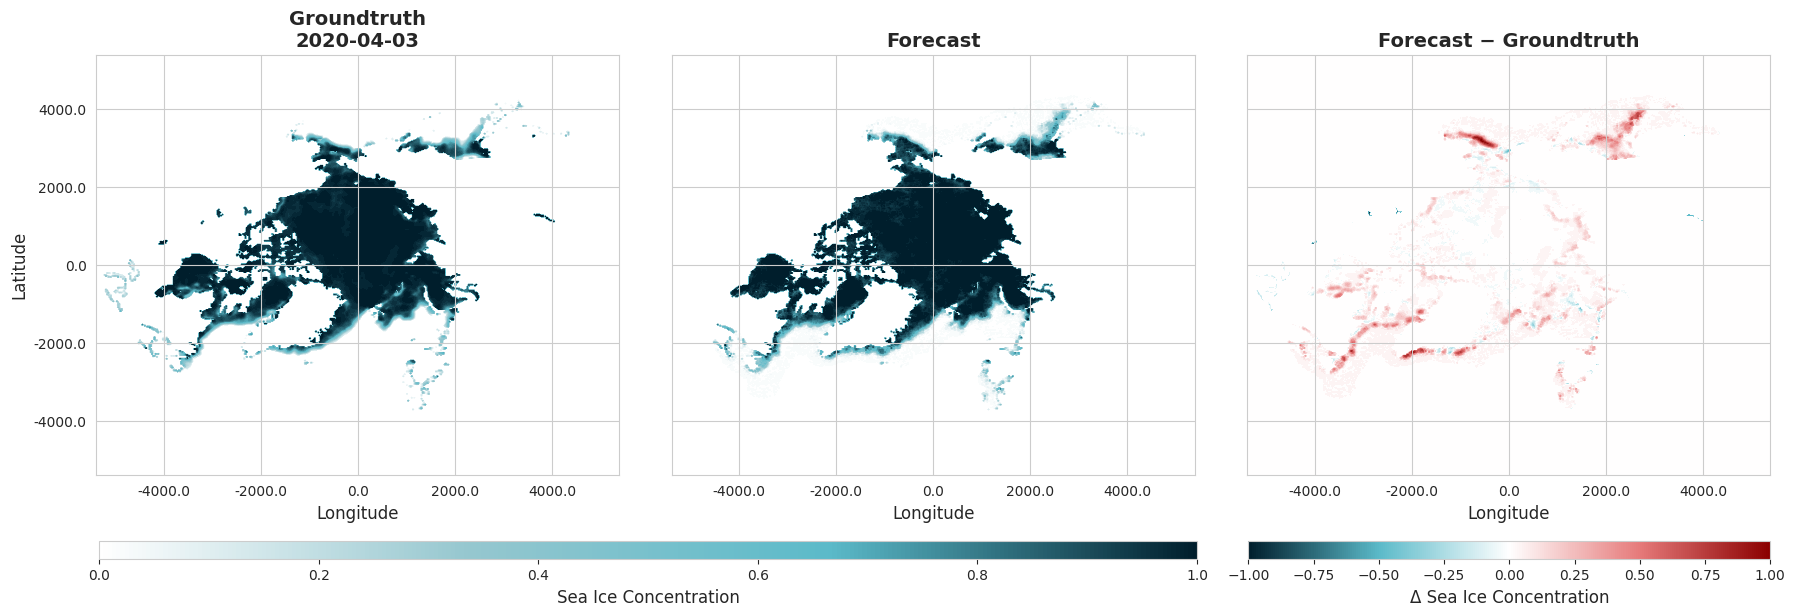

In [79]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

# --- load / select frames ---
fc_flat = fc.isel(time=1)
timestamp = pd.to_datetime(fc.time.values[1])

ds = xr.open_dataset("data/osisaf/north/siconca/2020.nc")
# ice_conc = ds.isel(time=93).ice_conc #93 is 3 april
# ice_conc = ds.isel(time=112).ice_conc #112 is 22 April
# ice_conc = ds.isel(time=94).ice_conc #94 is 4 april
ice_conc = ds.isel(time=95).ice_conc #95 is 5 april

# --- align grids (important) ---
ice_conc_interp = ice_conc.interp_like(fc_flat)

# --- difference ---
diff = fc_flat - ice_conc_interp

# --- colormaps ---
ppt_colors = ["#FFFFFF", "#96C7CF", "#5BBAC9", "#001E2C"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("ppt_cmap", ppt_colors)

diff_colors = ["#001E2C", "#5BBAC9", "#FFFFFF", "#E67A7A", "#8B0000"]
diff_cmap = mcolors.LinearSegmentedColormap.from_list("diff_cmap", diff_colors)

# --- shared vmin/vmax for the main (gt + fc) maps ---
vmin_main = float(np.nanmin([ice_conc_interp.values.min(), fc_flat.values.min()]))
vmax_main = float(np.nanmax([ice_conc_interp.values.max(), fc_flat.values.max()]))

# --- symmetric scale for difference ---
vmax_diff = float(np.nanmax(np.abs(diff.values)))
vmin_diff = -vmax_diff

# --- figure & axes ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Ground truth
im0 = ice_conc_interp.plot.contourf(
    ax=axes[0],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[0].set_title(f"Groundtruth\n{timestamp.strftime('%Y-%m-%d')}", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Longitude", fontsize=12)
axes[0].set_ylabel("Latitude", fontsize=12)

# Forecast
im1 = fc_flat.plot.contourf(
    ax=axes[1],
    levels=50,
    cmap=custom_cmap,
    vmin=vmin_main,
    vmax=vmax_main,
    add_colorbar=False,
    zorder=0,
)
axes[1].set_title("Forecast", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Longitude", fontsize=12)
axes[1].set_ylabel("")

# Difference
im2 = diff.plot.contourf(
    ax=axes[2],
    levels=50,
    cmap=diff_cmap,
    vmin=vmin_diff,
    vmax=vmax_diff,
    add_colorbar=False,
    zorder=0,
)
axes[2].set_title("Forecast − Groundtruth", fontsize=14, fontweight='bold')
axes[2].set_xlabel("Longitude", fontsize=12)
axes[2].set_ylabel("")

# --- Clean up axis tick labels ---
for i, ax in enumerate(axes):
    # Format longitude and latitude labels to be cleaner
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Reduce the number of ticks for cleaner look
    ax.xaxis.set_major_locator(plt.MaxNLocator(6))
    ax.yaxis.set_major_locator(plt.MaxNLocator(6))
    
    # Format tick labels to remove excessive decimals
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.1f'))
    
    # Remove y-axis labels for all except the first plot
    if i > 0:
        ax.set_yticklabels([])  # Remove y-tick labels but keep the ticks

# --- Better positioned colorbars ---
# Main colorbar - extended to match exact width of image 1 + image 2
cbar_ax1 = fig.add_axes([0.0515, 0.08, 0.61, 0.03])  # Extended width to match images 1+2
sm_main = plt.cm.ScalarMappable(cmap=custom_cmap, norm=plt.Normalize(vmin=vmin_main, vmax=vmax_main))
sm_main.set_array([])
cbar1 = fig.colorbar(sm_main, cax=cbar_ax1, orientation="horizontal")
cbar1.set_label("Sea Ice Concentration", fontsize=12)
cbar1.ax.tick_params(labelsize=10)

# Diff colorbar - extended to match exact width of image 3
cbar_ax2 = fig.add_axes([0.69, 0.08, 0.29, 0.03])  # Extended width to match image 3
sm_diff = plt.cm.ScalarMappable(cmap=diff_cmap, norm=plt.Normalize(vmin=vmin_diff, vmax=vmax_diff))
sm_diff.set_array([])
cbar2 = fig.colorbar(sm_diff, cax=cbar_ax2, orientation="horizontal")
cbar2.set_label("Δ Sea Ice Concentration", fontsize=12)
cbar2.ax.tick_params(labelsize=10)

# Adjust layout to make more room for colorbars (increased bottom margin)
plt.subplots_adjust(top=0.92, bottom=0.22, left=0.05, right=0.98, wspace=0.1)

plt.savefig(
    f"ddpm_forecast_comparison_{timestamp.strftime('%Y%m%d')}_ISAR8_PROTOTYPE_2018_2020_NORTH_test1to7Apr.png",
    dpi=300,
    bbox_inches="tight",
    facecolor='white'
)
plt.show()